In [8]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

plt.style.use('ggplot')

from helperfunctions import hide_code_in_slideshow

np.random.seed(1)

# import pymc3 as pm
# import arviz as az

import warnings
warnings.simplefilter('ignore')

# Gaussian Processes
## A Practical Introduction

### Henk Kortier, School of AI Enschede, 12-03-2020

&#9658; **Definition**: _A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution_ ([Rasmussen and Williams](http://www.gaussianprocess.org/gpml/)).

<center><img src="figures/rwcover.gif" width="800"></center>

# Content:
1. `whoami`
2. Motivation
3. Probability Fundamentals
    - Uncertainty (pdf)
    - Prior and Likelihood
    - Bayes' formula
    - Marginalisation and Conditioning
4. Normal distribution Fundamentals
    - Why normal distributions (Gaussian)
    - Univariate
    - Multivariate
    - Marginalisation and Conditioning 
5. Gaussian Processes
    - Covariance function
    - Regression example
    - Non gaussian likelihood example
    - 2D input example 

# `whoami`

- Background:
    - Electrical Engineering @UT (MSc.)
    - Estimation of body limbs using inertial and magnetic sensors @UT (Phd.)
- Work experience:
    - Lectoraat mechatronica @Saxion, experienced in Sensor Fusion and Inertial Sensing applied in localization and navigation.
<center><img src="figures/magMapping.jpg" width="800"></center>

# Motivation

### Human Learning $\neq$ Deep Learning

<span style="color:red">**Life-long**</span> learning with <span style="color:red">**small**</span> chunks of data in a <span style="color:red">**non-stationary**</span> world

<span style="color:blue">*VS*</span>

<span style="color:red">**Bulk**</span> learning from a <span style="color:red">**large**</span> amount of data in a <span style="color:red">**stationary**</span> world

- Motivation is in the utility 
- There is a lot of messy data (noisy, non-linear, missing, 
- Focus on regression analysis

- Linear regression ($y= \beta_1 x  + beta_0 + e$) where e is Norm. Distr.
- Non-linear relationships using linear models: logistic regression
- Polynomial regression



Of course, like almost everything in machine learning, we have to start from regression. Let’s revisit the problem: somebody comes to you with some data points (blue points in image right), and we would like to make some prediction of the value of y with a specific x (dashed red line).

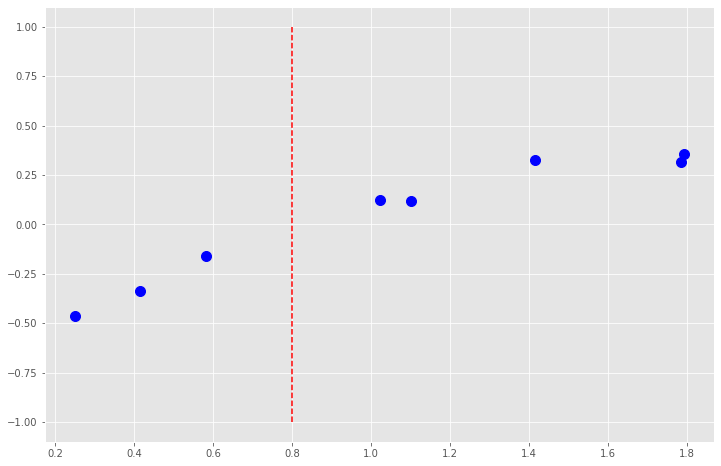

In [46]:
#hide_code_in_slideshow()
np.random.seed(3)

N = 8
x = np.sort(2*np.random.rand(N))
y = np.sin(x) + .05*np.random.randn(N)
y -= np.sin(np.pi/4)

plt.figure(figsize=(12,8))
plt.plot(x,y,'bo', markersize=10);
plt.vlines(.8,ymin=-1,ymax=1,colors='r',linestyle='dashed');

Typically we would perform a polynomial regression. And increase the polynomial degree such that the RMSE, or any other error metric, is minimal.

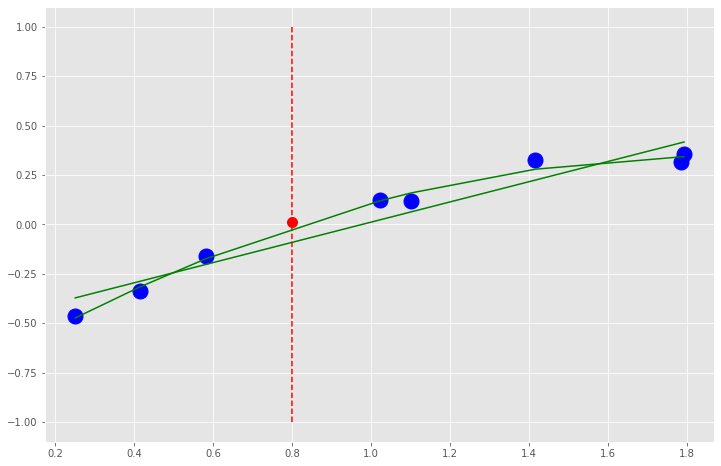

In [47]:
#hide_code_in_slideshow()

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

regr = linear_model.LinearRegression()
regr.fit(x[:,None], y[:,None])
y_pred = regr.predict(x[:,None])
   
poly_reg = PolynomialFeatures(degree=2)
x_poly = poly_reg.fit_transform(x[:,None])
pol_reg = linear_model.LinearRegression()
pol_reg.fit(x_poly, y[:,None])
y_poly_pred = pol_reg.predict(poly_reg.fit_transform(x[:,None]))

plt.figure(figsize=(12,8))
plt.plot(x,y,'bo', markersize=15)
plt.vlines(.8,ymin=-1,ymax=1,colors='r',linestyle='dashed');
plt.plot(x,y_pred,'g-');
plt.plot(x,y_poly_pred,'g -'); #poly pred
plt.plot(.8,np.sin(.8)-np.sin(np.pi/4),'ro',markersize=10); # true point

# Probabilistic modeling / Bayesian inference


## $$ p(y_{*} \mid y, x, x_{*}) $$

> Uncertainty can be represented as a set of possible outcomes and their respective likelihood —called a **probability distribution**

> Probabilistic modeling: Make predictions and inferences based on probability distributions. You manipulate pdf's to get your answers.

- Scarcity of training data
- Mismatch between the chosen prediction functions and the set of possible

# Probabilistic programming

## Data $D$ and Unknowns $\theta$ 

| Name | Symbol  | Explanation |
|------|---------|--------------|
| Prior | $p (\theta) $ | Knowledge of the unknown before you've seen any data. |
| Likelihood | $ p (D | \theta) $ | All the data that could influence the unknowns. |
| Posterior | $p (\theta | D) $ | Belief of the unknowns given the data. |

### Conditioning

$ p(D \mid \theta) = \frac{p(D, \theta)}{p(\theta)}$

### Marginalization

$ p(D) = \int_{\theta} p(D,\theta) d\theta = \int_{\theta} p(D \mid \theta) p(\theta) d \theta $

# Bayes law
# $$ \underbrace{Pr(\theta | D)}_{\text{Posterior}} = \dfrac{\overbrace{Pr(D | \theta)}^{\text{Likelihood}} ~~\overbrace{Pr(\theta)}^{\text{Prior}}}{\underbrace{Pr(D)}_{\text{Evidence (data)}}}$$ 

<!-- # $$ \underbrace{Pr(\theta | D)}_{\text{Posterior}} \propto \prod_{i=1}^{N} \overbrace{Pr(D_i | \theta)}^{\text{Likelihood}} ~~\overbrace{Pr(\theta)}^{\text{Prior}}$$ -->

Theta could be anything, it is unknown, hence a parameter, state, hypothesis, function, etc.
The lower plot gives the proportional relationship between posterior and likelihood*prior

![figures/bayes_montyhall.png](figures/bayes_montyhall.png)

[Bayes - Monty Hall](Bayes_MontyHall.ipynb)]

-------------------

# Gaussian Fundamentals

## Why Gaussians: Law of large numbers / Central Limit Theorem

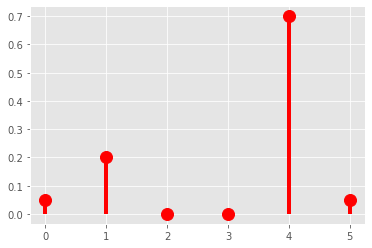

In [59]:
# Create a discrete distribution (like an unfair dice)
xk = np.arange(6)
pk = (0.05, 0.2, 0,0 , 0.7, 0.05)
custm = stats.rv_discrete(name='custm', values=(xk, pk))

fig, ax = plt.subplots(1, 1)
ax.plot(xk, custm.pmf(xk), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, custm.pmf(xk), colors='r', lw=4)
plt.show()

Sample 1: Mean of 200 trows: 3.126


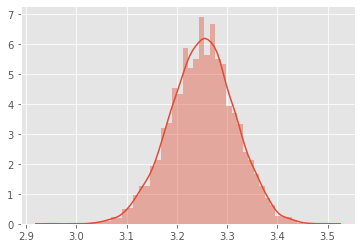

In [60]:
sizes = 500*np.ones((10000,1)).astype(int) #create array of 200's with length 100000
means = [np.mean(custm.rvs(size=size)) for size in sizes] 
print("Sample 1: Mean of 200 trows: {}".format(np.mean(custm.rvs(size=500))))
sns.distplot(np.array(means),);

## Gaussian Fundamentals

$$
p(x \mid \mu, \Sigma) = (2 \pi)^{-k/2} |\Sigma|^{-1/2} \exp{(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu) }
$$

![Multivariate_Gaussian](figures/Multivariate_Gaussian.png)

## Covariance matrix

[Multivariate Covariance matrix](https://www.jgoertler.com/visual-exploration-gaussian-processes/#Multivariate)

|No correlation| Little correlation|
|--------------|--------------------|
|![No correlation](figures/cov_nocor.png)|![Correlation](figures/cov_littlecor.png)

## Marginalisation & Conditioning of gaussians

[Marginalisation and Conditioning](https://www.jgoertler.com/visual-exploration-gaussian-processes/#MarginalizationConditioning)

$$
p(y_1, y_2) \sim \mathcal{N}
\begin{pmatrix}
\begin{bmatrix}
a\\
b
\end{bmatrix}
\begin{bmatrix}
A & B \\
B^T & C
\end{bmatrix}
\end{pmatrix}
$$

### Marginalisation
$p(y_1) = \mathcal{N}(a,A)$
$p(y_2) = \mathcal{N}(b,C)$

### Conditioning
$p(y_1|y_2) = \mathcal{N}(a + BC^{-1}(y_2-b), A-BC^{-1}B^T)$

Note: sum, marginal and conditional gives you Gaussians back

## Conditioning

|Conditioning| Effect of correlation on conditioning|
|:-:|:-:|
|![Conditioning](figures/conditioning.png)|![Conditioning](figures/effectOfCorrelationOnConditioning.gif)|

Visualize relation between different dimensions

![randomSamplesCorrelation](figures/randomSamplesCorrelation.png)

|Joint pdf | Conditional pdf|
|:-:|:-:|
|![randomSamplesCorrelationJoint](figures/randomSamplesCorrelationJoint.gif)|![randomSamplesCorrelationCondition](figures/randomSamplesCorrelationCondition.gif)|

|Joint pdf | Conditional pdf| Stats |
|:-:|:-:| :-: |
|![randomSamplesCorrelationJoint](figures/randomSamplesCorrelationJoint20.gif)|![randomSamplesCorrelationCondition](figures/randomSamplesCorrelationCondition20.gif)|![randomSamplesCorrelationCondition](figures/randomSamplesCorrelationStats.png)|

![GP](figures/randomSampleToGP.png)

# Probabilistic programming with normal distributions



# Gaussian Proces

A GP defines a prior over functions, which can be converted into a posterior over functions once we have seen some data. Although it might seem difficult to represent a distribution over a function, it turns out that we only need to be able to define a distribution over the function’s values at a finite, but arbitrary, set of points, say $x_1,…,x_N$. A GP assumes that $p(f(x_1),…,f(x_N))$ is jointly Gaussian, with some mean $\mu(x)$ and covariance $\Sigma(x)$ given by $\Sigma_{i,j} = k(x_i,x_j)$, where $k$ is a positive definite kernel function. The key idea is that if $x_i$ and $x_j$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too.

# Gaussian proces prior and prediction posterior distributions

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')).$$

- $m(\mathbf{x})$ is the Mean function
- $k(\mathbf{x}, \mathbf{x}')$ is the Covariance function or Kernel

a typical choice for both 

- $m(\mathbf{x}) = 0$
- $k(\mathbf{x}, \mathbf{x}') = \sigma^2 \exp{\left( \frac{-l (x-x')^2}{2} \right)}$ which is the SE, RBF, etc 

The Gaussian process generalizes the Gaussian distribution to this setting by describing any finite subset of (random) function values by a joint Gaussian distribution.

## GP Regression

- Measurement Model: $y = f(x) + e,$ with $e \sim \mathcal{N}(0,\sigma_n^2)$, and:
- GP prior: $f(x) = p(f \mid X) \sim \mathcal{GP}\left( m(\mathbf{x}), K(\mathbf{x}, \mathbf{x'}) \right)$

We have the datat (observations $y$ at train locations $X$) and GP prior, let's perform Bayesian inference to calculate the test outputs at test locations $X_{*}$. We need the joint distribution:

$$ p(y,f_{*}) = \begin{bmatrix}
y\\
f_*\\
\end{bmatrix} \sim  \mathcal{N}
\begin{pmatrix}
\mathbf{0},
\begin{bmatrix}
K(X, X) + \sigma_n^2 I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{bmatrix}
\end{pmatrix}
$$

Marginalization gives us the posterior prediction:

\begin{align}
p(f_{*} \mid X,y,X_{*}) &= \int p(f_* \mid X_*, f) p(f | X,y) df \\
&= \mathcal{N} \left( f_{*} \mid \mu_*, \Sigma_* \right)
\end{align} 

with:

- $\mu_* = K_*^T K_y^{-1} y$
- $\Sigma_* = K_{*,*} - K_{*}^T K_y^{-1} K_{*} $

Here, $K$ is the matrix we get by applying the kernel function to our observed $x$ values, i.e. the similarity of each observed $x$ to each other observed $x$. $K_*$ gets us the similarity of the training values to the test values whose output values we’re trying to estimate. $K_{**}$ gives the similarity of the test values to each other.

- Marginal likelihood: $p(y|X) = \int p(y|f,X) p(f|X) df $ 

- $p(y) \sim \mathcal{N} \left( 0, K+\sigma_n^{2}I \right)$
- $\log p(y|X) = - \frac{1}{2} y^T \left( K+\sigma_n^{2}I  \right) y - \log( | K+\sigma_n^{2}I |) -\frac{n}{2} \log 2\pi$


Important Hyperparameters

- lengthscale
- signal variance
- noise variance

## Example sample from GP Prior

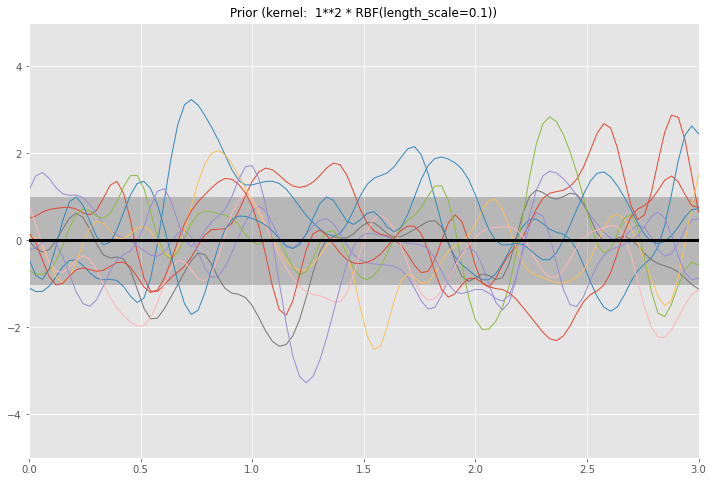

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(length_scale=.1, length_scale_bounds=(1e-1, 10.0))

gp = GaussianProcessRegressor(kernel=kernel)

# Plot prior
plt.figure(figsize=(12, 8))
X_ = np.linspace(0, 3, 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.xlim(0, 3)
plt.ylim(-5, 5)
plt.title("Prior (kernel:  %s)" % kernel, fontsize=12);

## Add data end calculate predictive posterior

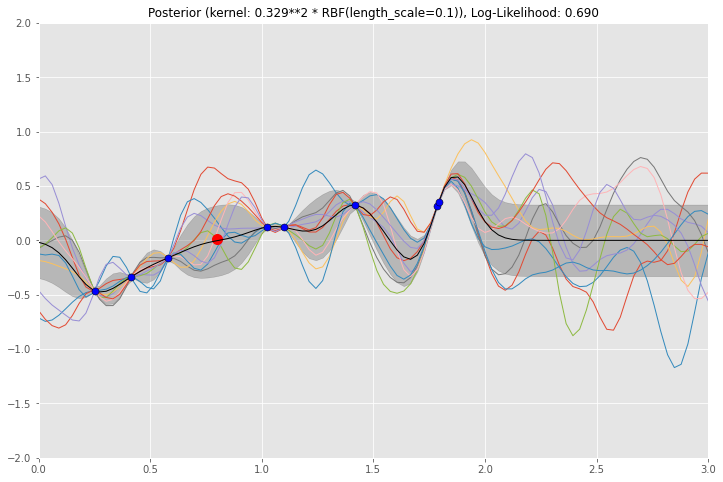

In [70]:
# Generate data and fit GP
X = x[:,np.newaxis]
gp.fit(X, y)

plt.figure(figsize=(12, 8))
X_ = np.linspace(0, 3, 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=1, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')

y_samples = gp.sample_y(X_[:, np.newaxis], 10)
plt.plot(X_, y_samples, lw=1)
plt.scatter(X[:, 0], y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))

plt.plot(.8,np.sin(.8)-np.sin(np.pi/4),'ro',markersize=10); # true value

plt.xlim(0, 3)
plt.ylim(-2, 2)
plt.title("Posterior (kernel: %s), Log-Likelihood: %.3f" % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)), fontsize=12);

# Steps
1. Define a covariance function (e.g. RBF, Constant, etc)
2. Perform inference given the test inputs $x_*$ and outputs $y_*$
3. Optimize the hyperparameters (MAP or full pdf (MCMC))
4. Do anything you want with the model
    - Sample from the posterior pdf
    - Return the posterior mean and covariance

# Python tools

- GPy
- GPFlow (TensorFlow) Variational Inference/MCMC focus
- GPyTorch (PyTorch)
- Scikit-learn
- Pymc3 (Theano, MCMC focus)

## Advantages

- ### Gaussian processes know what they don’t know:


![classifications](figures/classification.png)


- ### Incorporation of expert/domain knowledge

![classifications](figures/kernelchoice.png)

## Challenges

- ### Vanilla GP scales badly with data: Calculations: $\mathcal{O}(N^3)$, Storage: $\mathcal{O}(N^2)$
    - Lot of activity lately to 'circumvent' this (hence 1e6 datapoint is not an issue anymore):
        - Sparse approximation methods (M inducing point, with M<<N)
        - Fourier projections 
        - Blackbox matrix matrix inducing (GPytorch)
        - GPU
        
- ### Non-conjugate priors cannot be solved in closed form, hence Laplace/KL/EP/MCMC is required.        

## Sources:
    
- [GP Book](http://www.gaussianprocess.org/gpml/)
- [An Intuitive Guide To Gaussian Processes](https://towardsdatascience.com/an-intuitive-guide-to-gaussian-processes-ec2f0b45c71d)
- [Gaussian Processes for dummies](https://katbailey.github.io/post/gaussian-processes-for-dummies/)
- [Visual Exploration of GP](https://www.jgoertler.com/visual-exploration-gaussian-processes/)